# Metrics for training + validation

In [ ]:
#y_true = y_test
#y_pred = test_preds
#def dice_coef(y_true, y_pred, smooth=1):
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


#def dice_coef_loss(y_true, y_pred):
#    return -dice_coef(y_true, y_pred)


#hi = y_test / 255
#hi = K.flatten(hi)
#hi = tf.convert_to_tensor(hi, dtype=None)
#pred = test_preds
#pred = K.flatten(pred)
#pred = tf.convert_to_tensor(test_preds, dtype=None)

def dice_coef(a, b):
          #  hi = K.hi
          #  hi = hi / 255
    
          #    hi = tf.convert_to_tensor(hi, dtype=None)
          #    pred = tf.convert_to_tensor(test_preds, dtype=None)
    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a 
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

# Libraries

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from tensorflow import keras

# U-net++

In [ ]:
from keras import backend as K
from keras.layers import concatenate, Conv2DTranspose, Activation
from keras.layers import BatchNormalization


from keras.layers import Conv2D, Input, AvgPool2D
from keras.models import Model

dropout_rate = 0.5

#input_shape = (512, 512, 3)
#n_labels    = 3

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def model_build_func(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision==True:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.054,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)
    
    opt = keras.optimizers.Adam(learning_rate=3e-4)

    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=[dice_coef, jaccard_index])
    #dice_coef, jaccard_index

    return model

In [ ]:
input_shape = (512,512,3)
n_labels = 3
model = model_build_func(input_shape, n_labels)
model.summary()

# Training

In [ ]:
print(x_train.shape)
print(y_train.shape)
filepath = "./model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [checkpoint]
#earlystopper,
history = model.fit(total_x_train, total_y_train, validation_split=0.2, batch_size=1, epochs=30, callbacks=callbacks_list)



Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 0.4463 - dice_coef: 0.5014 - jaccard_index: 0.3465
Epoch 00001: val_loss improved from inf to 1.13130, saving model to ./model.h5
32/32 [==============================] - 5s 165ms/step - loss: 0.4463 - dice_coef: 0.5014 - jaccard_index: 0.3465 - val_loss: 1.1313 - val_dice_coef: 0.1882 - val_jaccard_index: 0.1131
Epoch 2/30
32/32 [==============================] - ETA: 0s - loss: 0.2280 - dice_coef: 0.7615 - jaccard_index: 0.6195
Epoch 00002: val_loss did not improve from 1.13130
32/32 [==============================] - 4s 121ms/step - loss: 0.2280 - dice_coef: 0.7615 - jaccard_index: 0.6195 - val_loss: 1.5579 - val_dice_coef: 0.2228 - val_jaccard_index: 0.1504
Epoch 3/30
32/32 [==============================] - ETA: 0s - loss: 0.1964 - dice_coef: 0.7996 - jaccard_index: 0.6695
Epoch 00003: val_loss improved from 1.13130 to 1.02074, saving model to ./model.h5
32/32 [==============================] - 4s 132ms/step - loss: 0.1964 - dice_coef: 0.7996 - jaccard_index: 0.6695 - val_loss: 1.0207 - val_dice_coef: 0.6630 - val_jaccard_index: 0.5225
Epoch 4/30
32/32 [==============================] - ETA: 0s - loss: 0.1921 - dice_coef: 0.7949 - jaccard_index: 0.6639
Epoch 00004: val_loss did not improve from 1.02074
32/32 [==============================] - 4s 122ms/step - loss: 0.1921 - dice_coef: 0.7949 - jaccard_index: 0.6639 - val_loss: 2.7537 - val_dice_coef: 0.5714 - val_jaccard_index: 0.4096
Epoch 5/30
32/32 [==============================] - ETA: 0s - loss: 0.1761 - dice_coef: 0.8156 - jaccard_index: 0.6918
Epoch 00005: val_loss did not improve from 1.02074
32/32 [==============================] - 4s 121ms/step - loss: 0.1761 - dice_coef: 0.8156 - jaccard_index: 0.6918 - val_loss: 9.7887 - val_dice_coef: 0.5285 - val_jaccard_index: 0.3657
Epoch 6/30
32/32 [==============================] - ETA: 0s - loss: 0.1670 - dice_coef: 0.8277 - jaccard_index: 0.7085
Epoch 00006: val_loss improved from 1.02074 to 0.95760, saving model to ./model.h5
32/32 [==============================] - 4s 133ms/step - loss: 0.1670 - dice_coef: 0.8277 - jaccard_index: 0.7085 - val_loss: 0.9576 - val_dice_coef: 0.6648 - val_jaccard_index: 0.5382
Epoch 7/30
32/32 [==============================] - ETA: 0s - loss: 0.1623 - dice_coef: 0.8335 - jaccard_index: 0.7180
Epoch 00007: val_loss improved from 0.95760 to 0.77706, saving model to ./model.h5
32/32 [==============================] - 4s 136ms/step - loss: 0.1623 - dice_coef: 0.8335 - jaccard_index: 0.7180 - val_loss: 0.7771 - val_dice_coef: 0.6195 - val_jaccard_index: 0.4866
Epoch 8/30
32/32 [==============================] - ETA: 0s - loss: 0.1536 - dice_coef: 0.8375 - jaccard_index: 0.7246
Epoch 00008: val_loss improved from 0.77706 to 0.53288, saving model to ./model.h5
32/32 [==============================] - 4s 132ms/step - loss: 0.1536 - dice_coef: 0.8375 - jaccard_index: 0.7246 - val_loss: 0.5329 - val_dice_coef: 0.6512 - val_jaccard_index: 0.5248
Epoch 9/30
32/32 [==============================] - ETA: 0s - loss: 0.1490 - dice_coef: 0.8469 - jaccard_index: 0.7366
Epoch 00009: val_loss did not improve from 0.53288
32/32 [==============================] - 4s 121ms/step - loss: 0.1490 - dice_coef: 0.8469 - jaccard_index: 0.7366 - val_loss: 0.6267 - val_dice_coef: 0.6642 - val_jaccard_index: 0.5419
Epoch 10/30
32/32 [==============================] - ETA: 0s - loss: 0.1491 - dice_coef: 0.8466 - jaccard_index: 0.7376
Epoch 00010: val_loss did not improve from 0.53288
32/32 [==============================] - 4s 121ms/step - loss: 0.1491 - dice_coef: 0.8466 - jaccard_index: 0.7376 - val_loss: 0.6957 - val_dice_coef: 0.6525 - val_jaccard_index: 0.5324
Epoch 11/30
32/32 [==============================] - ETA: 0s - loss: 0.1445 - dice_coef: 0.8499 - jaccard_index: 0.7421
Epoch 00011: val_loss did not improve from 0.53288
32/32 [==============================] - 4s 121ms/step - loss: 0.1445 - dice_coef: 0.8499 - jaccard_index: 0.7421 - val_loss: 0.9658 - val_dice_coef: 0.6452 - val_jaccard_index: 0.4977
Epoch 12/30
32/32 [==============================] - ETA: 0s - loss: 0.1416 - dice_coef: 0.8539 - jaccard_index: 0.7475
Epoch 00012: val_loss did not improve from 0.53288
32/32 [==============================] - 4s 121ms/step - loss: 0.1416 - dice_coef: 0.8539 - jaccard_index: 0.7475 - val_loss: 1.0942 - val_dice_coef: 0.6008 - val_jaccard_index: 0.4412
Epoch 13/30
32/32 [==============================] - ETA: 0s - loss: 0.1355 - dice_coef: 0.8614 - jaccard_index: 0.7586
Epoch 00013: val_loss did not improve from 0.53288
32/32 [==============================] - 4s 123ms/step - loss: 0.1355 - dice_coef: 0.8614 - jaccard_index: 0.7586 - val_loss: 0.7272 - val_dice_coef: 0.6291 - val_jaccard_index: 0.4765
Epoch 14/30
32/32 [==============================] - ETA: 0s - loss: 0.1294 - dice_coef: 0.8652 - jaccard_index: 0.7644
Epoch 00014: val_loss did not improve from 0.53288
32/32 [==============================] - 4s 121ms/step - loss: 0.1294 - dice_coef: 0.8652 - jaccard_index: 0.7644 - val_loss: 0.8271 - val_dice_coef: 0.6520 - val_jaccard_index: 0.5259
Epoch 15/30
32/32 [==============================] - ETA: 0s - loss: 0.1236 - dice_coef: 0.8720 - jaccard_index: 0.7745
Epoch 00015: val_loss did not improve from 0.53288
32/32 [==============================] - 4s 122ms/step - loss: 0.1236 - dice_coef: 0.8720 - jaccard_index: 0.7745 - val_loss: 0.6106 - val_dice_coef: 0.6383 - val_jaccard_index: 0.5109
Epoch 16/30
32/32 [==============================] - ETA: 0s - loss: 0.1246 - dice_coef: 0.8725 - jaccard_index: 0.7758
Epoch 00016: val_loss improved from 0.53288 to 0.43500, saving model to ./model.h5
32/32 [==============================] - 4s 132ms/step - loss: 0.1246 - dice_coef: 0.8725 - jaccard_index: 0.7758 - val_loss: 0.4350 - val_dice_coef: 0.6379 - val_jaccard_index: 0.5117
Epoch 17/30
32/32 [==============================] - ETA: 0s - loss: 0.1224 - dice_coef: 0.8761 - jaccard_index: 0.7815
Epoch 00017: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 119ms/step - loss: 0.1224 - dice_coef: 0.8761 - jaccard_index: 0.7815 - val_loss: 0.5260 - val_dice_coef: 0.6830 - val_jaccard_index: 0.5729
Epoch 18/30
32/32 [==============================] - ETA: 0s - loss: 0.1174 - dice_coef: 0.8794 - jaccard_index: 0.7864
Epoch 00018: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 121ms/step - loss: 0.1174 - dice_coef: 0.8794 - jaccard_index: 0.7864 - val_loss: 0.5537 - val_dice_coef: 0.6665 - val_jaccard_index: 0.5519
Epoch 19/30
32/32 [==============================] - ETA: 0s - loss: 0.1151 - dice_coef: 0.8818 - jaccard_index: 0.7913
Epoch 00019: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 121ms/step - loss: 0.1151 - dice_coef: 0.8818 - jaccard_index: 0.7913 - val_loss: 0.8291 - val_dice_coef: 0.6119 - val_jaccard_index: 0.4661
Epoch 20/30
32/32 [==============================] - ETA: 0s - loss: 0.1167 - dice_coef: 0.8822 - jaccard_index: 0.7910
Epoch 00020: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 120ms/step - loss: 0.1167 - dice_coef: 0.8822 - jaccard_index: 0.7910 - val_loss: 0.8204 - val_dice_coef: 0.6566 - val_jaccard_index: 0.5212
Epoch 21/30
32/32 [==============================] - ETA: 0s - loss: 0.1142 - dice_coef: 0.8851 - jaccard_index: 0.7952
Epoch 00021: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 121ms/step - loss: 0.1142 - dice_coef: 0.8851 - jaccard_index: 0.7952 - val_loss: 0.7615 - val_dice_coef: 0.6892 - val_jaccard_index: 0.5842
Epoch 22/30
32/32 [==============================] - ETA: 0s - loss: 0.1134 - dice_coef: 0.8869 - jaccard_index: 0.7981
Epoch 00022: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 121ms/step - loss: 0.1134 - dice_coef: 0.8869 - jaccard_index: 0.7981 - val_loss: 0.7298 - val_dice_coef: 0.5633 - val_jaccard_index: 0.4376
Epoch 23/30
32/32 [==============================] - ETA: 0s - loss: 0.1100 - dice_coef: 0.8914 - jaccard_index: 0.8056
Epoch 00023: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 122ms/step - loss: 0.1100 - dice_coef: 0.8914 - jaccard_index: 0.8056 - val_loss: 0.6431 - val_dice_coef: 0.6950 - val_jaccard_index: 0.5846
Epoch 24/30
32/32 [==============================] - ETA: 0s - loss: 0.1070 - dice_coef: 0.8926 - jaccard_index: 0.8077
Epoch 00024: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 121ms/step - loss: 0.1070 - dice_coef: 0.8926 - jaccard_index: 0.8077 - val_loss: 2.7062 - val_dice_coef: 0.5540 - val_jaccard_index: 0.3903
Epoch 25/30
32/32 [==============================] - ETA: 0s - loss: 0.1070 - dice_coef: 0.8945 - jaccard_index: 0.8104
Epoch 00025: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 120ms/step - loss: 0.1070 - dice_coef: 0.8945 - jaccard_index: 0.8104 - val_loss: 0.5072 - val_dice_coef: 0.6374 - val_jaccard_index: 0.5127
Epoch 26/30
32/32 [==============================] - ETA: 0s - loss: 0.0975 - dice_coef: 0.9023 - jaccard_index: 0.8230
Epoch 00026: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 121ms/step - loss: 0.0975 - dice_coef: 0.9023 - jaccard_index: 0.8230 - val_loss: 0.6158 - val_dice_coef: 0.6896 - val_jaccard_index: 0.5810
Epoch 27/30
32/32 [==============================] - ETA: 0s - loss: 0.0969 - dice_coef: 0.9033 - jaccard_index: 0.8247
Epoch 00027: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 121ms/step - loss: 0.0969 - dice_coef: 0.9033 - jaccard_index: 0.8247 - val_loss: 0.5282 - val_dice_coef: 0.6569 - val_jaccard_index: 0.5362
Epoch 28/30
32/32 [==============================] - ETA: 0s - loss: 0.0973 - dice_coef: 0.9036 - jaccard_index: 0.8253
Epoch 00028: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 122ms/step - loss: 0.0973 - dice_coef: 0.9036 - jaccard_index: 0.8253 - val_loss: 0.6317 - val_dice_coef: 0.6827 - val_jaccard_index: 0.5714
Epoch 29/30
32/32 [==============================] - ETA: 0s - loss: 0.0989 - dice_coef: 0.9053 - jaccard_index: 0.8279
Epoch 00029: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 125ms/step - loss: 0.0989 - dice_coef: 0.9053 - jaccard_index: 0.8279 - val_loss: 0.8355 - val_dice_coef: 0.4817 - val_jaccard_index: 0.3586
Epoch 30/30
32/32 [==============================] - ETA: 0s - loss: 0.0944 - dice_coef: 0.9050 - jaccard_index: 0.8274
Epoch 00030: val_loss did not improve from 0.43500
32/32 [==============================] - 4s 121ms/step - loss: 0.0944 - dice_coef: 0.9050 - jaccard_index: 0.8274 - val_loss: 0.9523 - val_dice_coef: 0.5970 - val_jaccard_index: 0.4715

# Plotting history

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

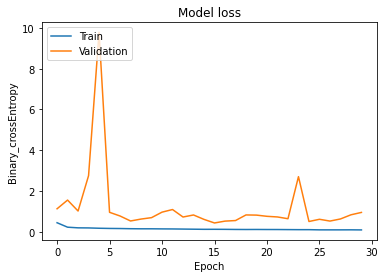

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

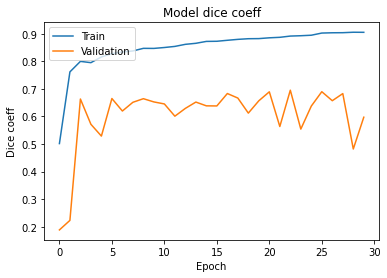

In [ ]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

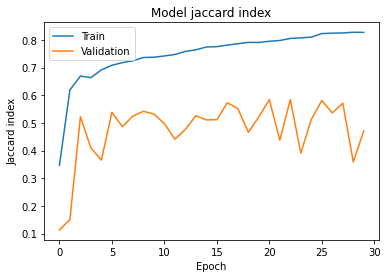